# Convolutional networks for MNIST

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math
from skimage import color
from skimage import data

# Convert labels to one-hot vectors

# Convert classes to indicator vectors
def one_hot(values,n_values=10):
    n_v = np.maximum(n_values,np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Get Mnist data and split into train validation and test

In [3]:
def get_mnist():

    data=np.float64(np.load('/project/cmsc25025/mnist/MNIST.npy'))
    labels=np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:50000]
    train_labels=one_hot(np.int32(labels[0:50000]))
    val_dat=data[50000:60000]
    val_labels=one_hot(np.int32(labels[50000:60000]))
    test_dat=data[60000:70000]
    test_labels=one_hot(np.int32(labels[60000:70000]))
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

# Get transformed Mnist data

In [5]:
def get_mnist_trans():
    test_trans_dat=np.float32(np.load('/project/cmsc25025/mnist/MNIST_TEST_TRANS.npy'))
    test_labels=one_hot(np.int32(np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))))
    return (test_trans_dat, test_labels)

## (c) Variability. Show few examples along the original images.

In [27]:
test_trans_data, test_labels = get_mnist_trans()

In [6]:
def show_image(nrows, ncols, dim, num_images, data):
    nrows = nrows
    ncols = ncols
    plt.figure(figsize=(ncols, nrows))
    for i in range(num_images):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(data[i].reshape((dim,dim)), cmap="gray")
        plt.axis("off")
    plt.show()

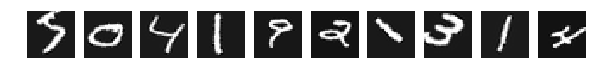

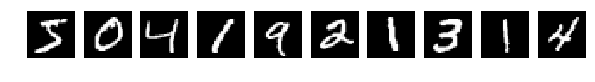

In [35]:
show_image(1, 10, 28, 10, test_trans_data)
show_image(1, 10, 28, 10, train[0])

# Convolution layer with relu

In [7]:
def conv_relu_layer(input,filter_size=[3,3],num_features=[1]):

    # Get number of input features from input and add to shape of new layer
    shape=filter_size+[input.get_shape().as_list()[-1],num_features]
    W = tf.get_variable('W',shape=shape) # Default initialization is Glorot (the one explained in the slides)
    b = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer) 
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b)
    return(relu)

# Fully connected layer

In [8]:
def fully_connected_layer(input,num_features):
    # Make sure input is flattened.
    flat_dim=np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1,flat_dim])
    shape=[flat_dim,num_features]
    W_fc = tf.get_variable('W',shape=shape) 
    b_fc = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer)
    fc = tf.matmul(input_flattened, W_fc) + b_fc
    return(fc)

# The network

In [9]:
# Below is the modified deeper network.

def create_network():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv2/weights", "conv2/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv3"):
            # Variables created here will be named "conv3/weights", "conv3/biases".
            relu3 = conv_relu_layer(pool2, filter_size=[5, 5],num_features=128)
            pool3 = tf.nn.max_pool(relu3, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv4"):
            # Variables created here will be named "conv4/weights", "conv4/biases".
            relu4 = conv_relu_layer(pool3, filter_size=[5, 5],num_features=256)
            pool4 = tf.nn.max_pool(relu4, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv5"):
            # Variables created here will be named "conv4/weights", "conv4/biases".
            relu5 = conv_relu_layer(pool4, filter_size=[5, 5],num_features=512)
            pool5 = tf.nn.max_pool(relu5, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv6"):
            # Variables created here will be named "conv4/weights", "conv4/biases".
            relu6 = conv_relu_layer(pool5, filter_size=[5, 5],num_features=1024)
            pool6 = tf.nn.max_pool(relu6, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool6,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=512)
            fc1r=tf.nn.relu(fc1)
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=1024)
            fc2r=tf.nn.relu(fc2)
   
    with tf.variable_scope("fc3"):
            fc3 = fully_connected_layer(fc2r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc3 = tf.identity(fc3, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc3),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc3, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc3

# Get loss and accuracy on a data set with output from final layer fc2

In [10]:
from scipy.special import logsumexp

def get_stats(data,labels):
    t1=time.time()
    lo=0.
    acc=0.
    delta=1000
    rr=np.arange(0,data.shape[0],delta)
    for i in rr:
        fc2_out=fc2.eval(feed_dict={x: data[i:i+delta], y_:labels[i:i+delta]})
        log_sf=logsumexp(fc2_out,axis=1).reshape((fc2_out.shape[0],1))-fc2_out
        lo+=np.mean(np.sum(labels[i:i+delta]*log_sf, axis=1))
        acc += np.mean(np.equal(np.argmax(fc2_out, axis=1),np.argmax(labels[i:i+delta], axis=1)))
    acc=acc/np.float32(len(rr))
    lo=lo/np.float32(len(rr))
    print('get stats time',time.time()-t1)
    # We return the final functions (they contain all the information about the graph of the network)
    return lo, acc

# Run one epoch

In [11]:
# Run the iterations of one epoch
def run_epoch(train,val,ii,batch_size,train_step_new):
        t1=time.time()
        # Randomly shuffle the training data
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        lo=0.
        acc=0.
        # Run disjoint batches on shuffled data
        for j in np.arange(0,len(y),batch_size):
            if (np.mod(j,5000)==0):
                print('Batch',j/batch_size)
            batch=(tr[j:j+batch_size],y[j:j+batch_size])
            train_step_new.run(feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:keep_prob})
        print('Epoch time',time.time()-t1)

In [12]:
def get_data(data_set):
    if (data_set=="cifar"):
        return(get_cifar())
    elif (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="mnist_transform"):
        return(get_mnist_trans())

# Show Convolutional Layer

In [13]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = sess.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Run the training. Save the model and test at the end¶

(70000, 784)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

conv1/W:0 [5, 5, 1, 32] 0.04919975
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028925586
conv2/b:0 [64] 0.0
conv3/W:0 [5, 5, 64, 128] 0.02042872
conv3/b:0 [128] 0.0
conv4/W:0 [5, 5, 128, 256] 0.014440567
conv4/b:0 [256] 0.0
conv5/W:0 [5, 5, 256, 512] 0.010206038
conv5/b:0 [512] 0.0
conv6/W:0 [5, 5, 512, 1024] 0.0072173136
conv6/b:0 [1024] 0.0
fc1/W:0 [1024, 512] 0.036089998
fc1/b:0 [512] 0.0
fc2/W:0 [512, 1024] 0.036089685
fc2/b:0 [1024] 0.0
fc3/W:0 [1024, 10] 0.04404048
fc3/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Batch 60.0
Batch 70.0
Batch 80.0
Batch 90.0
Epoch time 23.268731832504272
get stats time 5.664736747741699
Epoch 0 Train loss, accuracy 0.37518502312660224 0.8802799999999997
get stats time 0.9169051647186279
EPoch 0 Validation loss, a

Batch 60.0
Batch 70.0
Batch 80.0
Batch 90.0
Epoch time 17.856009006500244
get stats time 4.717625379562378
Epoch 30 Train loss, accuracy 0.0025285156941413883 0.9994200000000003
get stats time 0.9443085193634033
EPoch 30 Validation loss, accuracy 0.03922589325904847 0.9927999999999999
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Batch 60.0
Batch 70.0
Batch 80.0
Batch 90.0
Epoch time 17.869126081466675
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Batch 60.0
Batch 70.0
Batch 80.0
Batch 90.0
Epoch time 17.872971773147583
get stats time 4.745054244995117
Epoch 32 Train loss, accuracy 0.00687247440338135 0.9983
get stats time 0.9448862075805664
EPoch 32 Validation loss, accuracy 0.03763268704414367 0.9914999999999999
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Batch 60.0
Batch 70.0
Batch 80.0
Batch 90.0
Epoch time 17.939831018447876
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Batch 60.0
Batch 70.0
Batch 80.0
B

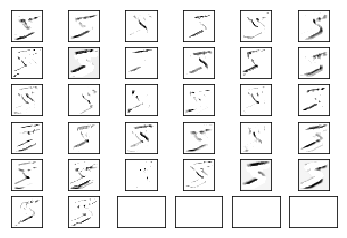

Model saved in path: tmp/model


In [14]:
# Run the training
import time
batch_size=500
step_size=.001
num_epochs=40
num_train=50000
minimizer="Adam"
data_set="mnist"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3

err_double_parameters = []

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

with tf.Session() as sess:
        train,val,test = get_data(data_set=data_set)
        ##############  The code commented below is used to test on the transformed data  #################
        
        #train = get_data(data_set=data_set)[0]
        #test_data, test_label = get_mnist_trans()
        #val = (test_data[50000:60000], test_label[50000:60000])
        #test = (test_data[60000:70000], test_label[60000:70000])
        
        ##############  The code commented above is used to test on the transformed data  #################
        
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                # Test set accuracy
                err_double_parameters.append(((1-ac)*num_train + (1-vac)*10000)/(num_train+10000))

        
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))

        image = train[0][0]
        #image = tf.reshape(train[0][0], [-1, dim, dim, nchannels])
        conv = tf.nn.conv2d(x_image, tf.trainable_variables()[0], strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(conv + tf.trainable_variables()[1])
        plot_conv_layer(relu, image)
    
        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)


## First convolutional layer shown above in the output window.

## Plot the error rate of original model on training and validation data

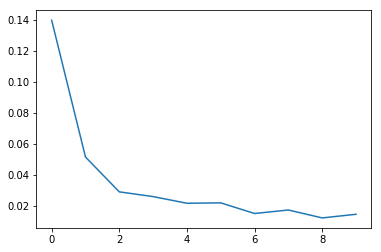

In [16]:
plt.plot(error_rate_trainval)

## Show one of the image sample.

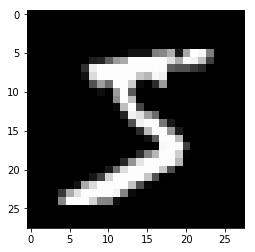

In [17]:
plt.imshow(train[0][0].reshape((28,28)), cmap = "gray")

# Experiment with Changing Parameters of the Network
Total number of parameters in the original model:
- 32+64+256+10 weights;
- 32+64+256+10 biases.

## i. Change layer parameters; Same number of layers

Original network: 
    - Test Accuracy: 0.9805
Reducing the parameter number by half:  
    - Test Accuracy: 0.9711
Doubling the parameter number:
    - Test Accuracy: 0.9809
conv1/W: 160 conv2/W: 320 fc1/W: 1024:
    - Test Accuracy: 0.9829

Analysis: 
- The accuracy on the test set increases as the number of parameters in each layer increases. 
- It takes longer to run a single epoch as the number of parameters increases.
- As the numebr of features increases, the convolutional layer is capturing more fine-grain detail of the image.

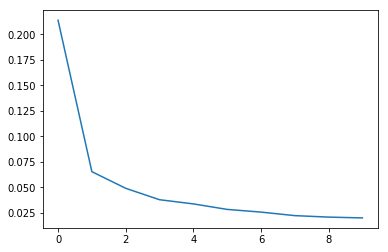

In [21]:
# Error rate when reducing the number of parameters
plt.plot(err_half_parameters)

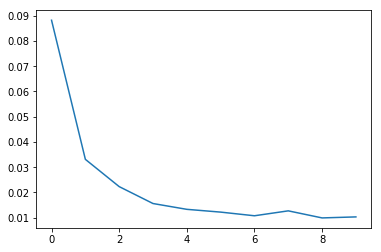

In [24]:
# Error rate when doubling the number of parameters
plt.plot(err_double_parameters)

## ii. Deeper Networks; Same number of parameters

Original network:
    - Test Accuracy: 0.9805
Deeper network with 4 convolutional layers (16,16,32,32) and 2 fully connected layers (256,10):
    - Test Accuracy: 0.9706
Deeper network with 6 convolutional layers (8,8,16,16,24,24) and 2 fully connected layers (256,10):
    - Test Accuracy: 0.9004
Deeper network with 6 convolutional layers (8,8,16,16,24,24) and 3 fully connected layers (128,128,10):
    - Test Accuracy: 0.9241

Analysis:
- Adding more convolutional layers actually decrease the test accuracy. This might be due to that more layers of features detection result in information loss.
- However, keeping the same number of convolutional layers but only increasing the fully connected layers restore the accuracy on the test images. Higher accuracy gotten then the original model when 40 epochs were run.
- As can be seen in the first convolutional layer printed out, with less features in the first layer, each filtered image capture the specific feature worse and the features are not good enough to distinguish each other. 

## iii. Best Architecture: 
Deeper network with 6 convolutional layers (32,64,128,256,512,1024) and 3 fully connected layers (512,1024,10):
- Test Accuracy: 0.9849
- On the whole training set: 
    - Test Accuracy: 0.9932

## (c) Variability. Results of changing the model.
Using original architecture: 
    - test accuracy 0.5683
Changes to the network architecture and the improvements are listed below:
    -  Change the pool size to [1,6,6,1]
        - Test Accuracy: 0.7116
    -  Change the pool size to [1,9,9,1], pool stride to [1,3,3,1]
        - Test Accuracy: 0.7274
    -  Change the pool size to [1,4,4,1], pool stride to [1,1,1,1], pooling method to average pool
        - Test Accuracy: 0.5882
    -  Change the pool size to [1,12,12,1], pool stride to [1,6,6,1]
        - Test Accuracy: 0.5985
    -  Change the pool size to [1,12,12,1], pool stride to [1,4,4,1]
        - Test Accuracy: 0.6664
    -  ***BEST***Change the pool size to [1,12,12,1], pool stride to [1,2,2,1]
        - Test Accuracy: 0.7257
        
Conclusion: The accuracy is boosted when mamking the pool size large and keeping the stride small. Max pooling gives better results than average pooling.

# Reload the model that was saved and continue training

In [11]:
# Reloading an existing model.

tf.reset_default_graph()
batch_size=500
step_size=.001
num_epochs=4
num_train=10000
data_set="mnist"
model_name="model"
Train=True
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3
    
with tf.Session() as sess:
    # Get data
    train, val, test=get_data(data_set=data_set)
    # Load model info
    saver = tf.train.import_meta_graph('tmp/'+model_name+'.meta')
    saver.restore(sess,'tmp/'+model_name) 
    graph = tf.get_default_graph()
    # Setup the placeholders from the stored model.
    x = graph.get_tensor_by_name('x:0')
    y_= graph.get_tensor_by_name('y:0')
    lr_ = graph.get_tensor_by_name('learning_rate:0')
    keep_prob_ = graph.get_tensor_by_name('keep_prob:0')
    accuracy=graph.get_tensor_by_name('helpers/ACC:0')
    cross_entropy=graph.get_tensor_by_name('cross_entropy_loss/LOSS:0')
    fc2=graph.get_tensor_by_name('OUT:0')
    # Get the minimization operation from the stored model
    if (Train):
        train_step_new = tf.get_collection("optimizer")[0]
        # Confirm training accuracy of current model before additional training
        acc=accuracy.eval(feed_dict={x: train[0][0:num_train], y_:train[1][0:num_train]})
        print('train acc',acc)

        ii=np.arange(0,num_train,1) 
        for i in range(num_epochs):  # Run epochs
            run_epoch(train,val,ii,batch_size,train_step_new)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
    # Test set accuracy

    print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))
    
    tf.add_to_collection("optimizer", train_step)
    saver = tf.train.Saver()
    save_path = saver.save(sess, "tmp/"+model_name)
    print("Model saved in path: %s" % save_path)

(70000, 784)
INFO:tensorflow:Restoring parameters from tmp/model
train acc 0.9652
Batch 0.0
Batch 10.0
Epoch time 0.8549635410308838
get stats time 0.2569692134857178
Epoch 0 Train loss, accuracy 0.09185025779008867 0.9731
get stats time 0.23220181465148926
EPoch 0 Validation loss, accuracy 0.106389400100708 0.9663
Batch 0.0
Batch 10.0
Epoch time 0.7483863830566406
Batch 0.0
Batch 10.0
Epoch time 0.7561037540435791
get stats time 0.240433931350708
Epoch 2 Train loss, accuracy 0.06468419432640075 0.9808
get stats time 0.25383830070495605
EPoch 2 Validation loss, accuracy 0.08916233117580415 0.9715999999999999
Batch 0.0
Batch 10.0
Epoch time 0.7247331142425537
test accuracy 0.9714
Model saved in path: tmp/model
